In [1]:
import numpy as np
import cv2
from PIL import Image
import onnxruntime
import datetime
import os
import re
import matplotlib.pyplot as plt

### MODNet Mode using ONNX Runtime

In [2]:
session = onnxruntime.InferenceSession("./model/pretrained/modnet.onnx", None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

In [3]:
def get_scale_factor(im_h, im_w, ref_size):
    if max(im_h, im_w) < ref_size or min(im_h, im_w) > ref_size:
        if im_w >= im_h:
            im_rh = ref_size
            im_rw = int(im_w / im_h * ref_size)
        elif im_w < im_h:
            im_rw = ref_size
            im_rh = int(im_h / im_w * ref_size)
    else:
        im_rh = im_h
        im_rw = im_w

    im_rw = im_rw - im_rw % 32
    im_rh = im_rh - im_rh % 32

    x_scale_factor = im_rw / im_w
    y_scale_factor = im_rh / im_h

    return x_scale_factor, y_scale_factor

In [4]:
# Foto: ROBYN BECK / AFP
image_path = os.path.join('images/lea.jpg')

## Inference with Files

In [5]:
filePattern = re.compile("(.*)\.(jpg|jpeg|png|git)$")

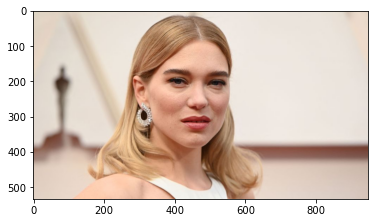

In [6]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


height = 533, width = 948, depth = 3
x = 0.9451476793248945, y = 0.9606003752345216


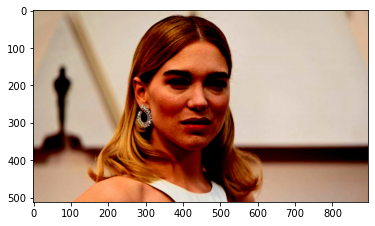

In [7]:
if len(img.shape) == 2:
    img = img[:, :, None]
if img.shape[2] == 1:
    img = np.repeat(img, 3, axis=2)
elif img.shape[2] == 4:
    img = img[:, :, 0:3]

# normalize values to scale it between -1 to 1
img = (img - 127.5) / 127.5

img_h, img_w, img_c = img.shape
print(f'height = {img_h}, width = {img_w}, depth = {img_c}')

x, y = get_scale_factor(img_h, img_w, 512)
print(f'x = {x}, y = {y}')

img = cv2.resize(img, None, fx=x, fy=y, interpolation=cv2.INTER_AREA)
plt.imshow(img);

In [8]:
img.shape

(512, 896, 3)

In [9]:
img = np.transpose(img)
img = np.swapaxes(img, 1, 2)
img = np.expand_dims(img, axis=0).astype("float32")

In [10]:
img.shape

(1, 3, 512, 896)

In [11]:
result = session.run([output_name], {input_name: img})

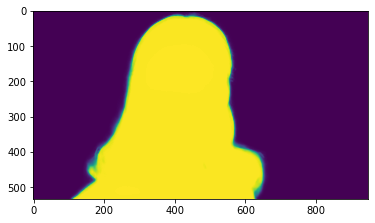

In [12]:
mask = (np.squeeze(result[0]) * 255).astype("uint8")
mask = cv2.resize(mask, dsize=(img_w, img_h), interpolation=cv2.INTER_AREA)
plt.imshow(mask);

In [13]:
image_mask_path = filePattern.sub(r"\1_mask.png", image_path)
cv2.imwrite(image_mask_path, mask);

In [14]:
img_PIL = Image.open(image_path)
mask = Image.fromarray(mask)
img_PIL.putalpha(mask)

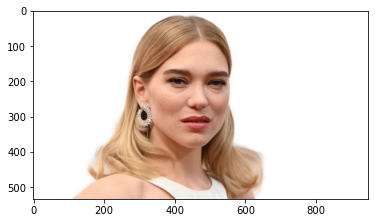

In [15]:
plt.imshow(img_PIL);

In [16]:
cropped_image_path = filePattern.sub(r"\1_cropped.png", image_path)
img_PIL.save(cropped_image_path)

In [17]:
!ls -al images

total 960
drwxr-xr-x   6 duerr  staff     192 29 Nov 18:45 .
drwxr-xr-x  14 duerr  staff     448 29 Nov 20:50 ..
-rw-r--r--@  1 duerr  staff   37357 29 Nov 18:45 lea.jpg
-rw-r--r--   1 duerr  staff  356282 29 Nov 20:50 lea_cropped.png
-rw-r--r--   1 duerr  staff   30881 29 Nov 20:50 lea_mask.png
-rw-r--r--@  1 duerr  staff   20301 22 Nov 21:57 ryan.jpg


## Inferece in Memory

In [36]:
from io import BytesIO
with open(image_path, 'br') as f:
    img = np.array(Image.open(BytesIO(f.read())))

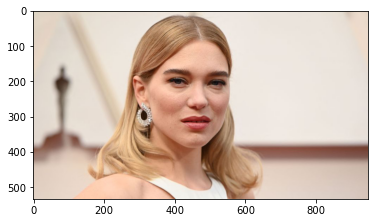

In [37]:
plt.imshow(img);

In [32]:
img_PIL = Image.fromarray(img)
img_PIL.putalpha(mask)

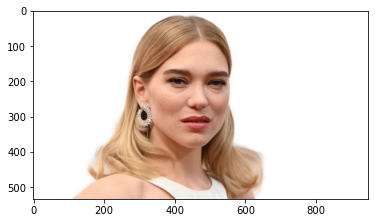

In [33]:
plt.imshow(img_PIL);

### Encode to base64 Data:URL

In [43]:
import base64
from io import BytesIO

buffered = BytesIO()
img_PIL.save(buffered, format="PNG")
img_PIL_base64 = base64.b64encode(buffered.getvalue())

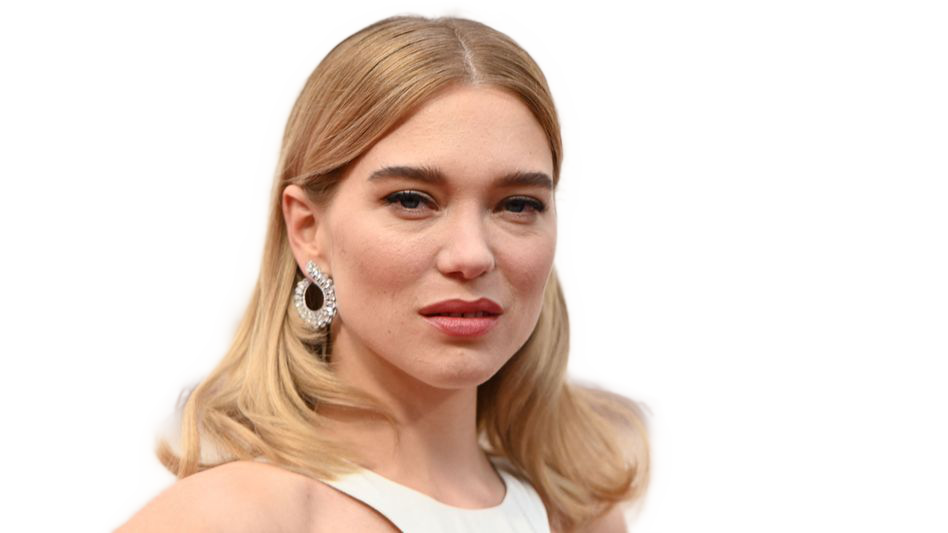

In [54]:
from IPython import display
from base64 import b64decode
display.Image(b64decode(img_PIL_base64), width=340)